In [1]:
from pathlib import Path
from matplotlib import pyplot as plt

import numpy as np

from jaxpower import Spectrum2Poles, WindowMatrix, CovarianceMatrix, BinnedStatistic, WindowRotationSpectrum2
from abacus_hf import get_measurement_fn, get_box_measurement_fn

rebin = 5
nmocks = 25
catalog_args = dict(zsnap=0.950, region='NGC', tracer='LRG', zrange=(0.8, 1.1))
imock = 0

fns = [get_measurement_fn(imock=0, **catalog_args, kind='covariance_mesh2spectrum').replace('.npy', f'_{key}.npy') for key in ['ww', 'ws', 'ss']]
covs = [CovarianceMatrix.load(fn).slice(slice(0, None, rebin)) for fn in fns]

In [2]:
covmatrix = sum(covs)
#covmatrix.plot(corrcoef=True, show=True);

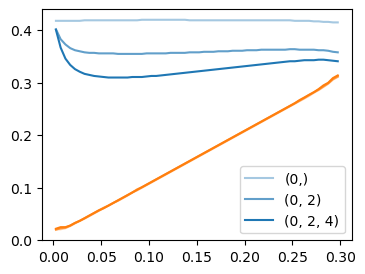

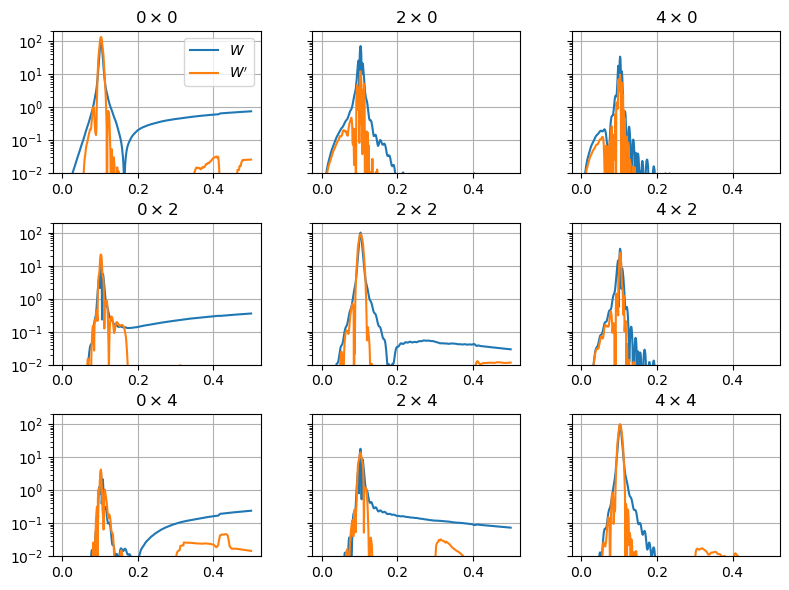

In [3]:
fn = get_measurement_fn(imock=0, **catalog_args, kind='rotation_mesh2spectrum_thetacut')

rotation = WindowRotationSpectrum2.load(fn)
rotation.plot_compactness(show=True)
fig = rotation.plot_wmatrix_slice(20)
for ax in fig.axes:
    ax.set_ylim(1e-2, 2e2)
plt.show()

In [4]:
pks = [Spectrum2Poles.load(get_measurement_fn(imock=imock, **catalog_args, kind='mesh2spectrum_thetacut_rotated')) for imock in range(nmocks)]
pk_cutsky_thetacut = Spectrum2Poles.mean(pks)
cov_cutsky_thetacut = Spectrum2Poles.cov(pks)
cov_cutsky_thetacut = cov_cutsky_thetacut.clone(value=np.diag(np.diag(cov_cutsky_thetacut.view())))
wmat_cutsky_thetacut = WindowMatrix.load(get_measurement_fn(imock=0, **catalog_args, kind='window_mesh2spectrum_thetacut_rotated'))
pk_box = Spectrum2Poles.mean([Spectrum2Poles.load(get_box_measurement_fn(imock=imock, **catalog_args, kind='mesh2spectrum')) for imock in range(nmocks)])
pk_box = pk_box.slice(slice(0, None, rebin))

wmat_box = WindowMatrix.load(get_box_measurement_fn(imock=0, **catalog_args, kind='window_mesh2spectrum'))

wmat_square = wmat_box.slice(slice(0, None, 5), axis='o').slice(slice(0, None, 5), axis='t')
# Invert the square window matrix
observable_to_theory = wmat_square.clone(value=np.linalg.inv(wmat_square.view()),
                                         theory=wmat_square.observable, observable=wmat_square.theory)

pk_box_deconvolved = observable_to_theory.dot(pk_box, return_type=None)

# Let's just do a spline interpolation of the "deconvolved" P(k)
# (one could do something better, fitting some real model given a preliminary covariance matrix)

from jax import numpy as jnp
from scipy import interpolate

def pk_theory_callable(k):
    # Insert 0 to enforce P(k=0) = 0
    x = jnp.insert(pk_box_deconvolved.x(0), 0, 0.)
    y = jnp.stack([jnp.insert(pk_box_deconvolved.view(projs=proj), 0, 0.) for proj in pk_box_deconvolved.projs])
    return interpolate.interp1d(x, y, kind='cubic', axis=-1, bounds_error=False, fill_value=0., assume_sorted=True)(k)

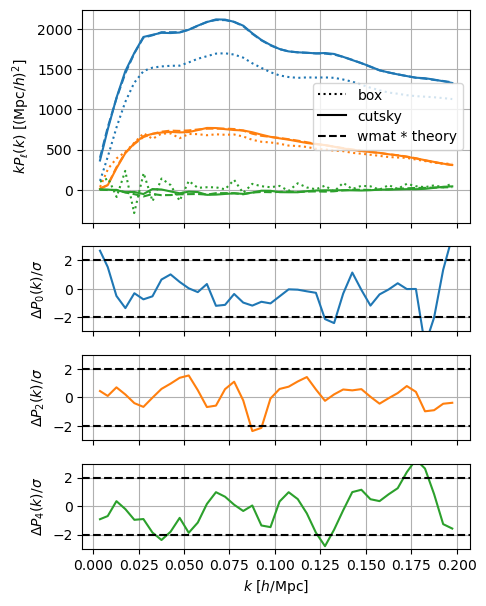

In [5]:
def plot_validation(pk_box, pk_cutsky, pk_theory_callable, wmat, cov_cutsky, klim=(0., 0.25), marg_shotnoise=False):
    wmat = wmat.select(xlim=klim, axis='o')
    kin = wmat.theory.x(projs=0)
    pk_theory = wmat.theory.clone(value=list(pk_theory_callable(kin)))
    pk_box, pk_cutsky, cov_cutsky = (pk.select(xlim=klim) for pk in [pk_box, pk_cutsky, cov_cutsky])
    ells = pk_cutsky.projs
    pk_std = [np.diag(cov_cutsky.select(projs=ell, select_projs=True))**0.5 / nmocks**0.5 for ell in ells]
    pk_wmat = wmat.dot(pk_theory.view(), return_type=None)
    if marg_shotnoise:
        pk_shotnoise = pk_theory.clone(value=[(ell == 0) * np.ones_like(pk_theory.view(projs=ell)) for ell in pk_theory.projs])
        diff = pk_wmat.view().real - pk_cutsky.view().real
        cov = cov_cutsky.view()
        grad = wmat.dot(pk_shotnoise)
        ph = np.linalg.solve(cov, grad)
        sn = 1. / grad.T.dot(ph) * ph.dot(diff)
        pk_wmat = wmat.dot(pk_theory.view() - sn * pk_shotnoise.view(), return_type=None)

    fig, lax = plt.subplots(1 + len(ells), figsize=(5, 7), sharey=False, sharex=True,
                gridspec_kw={'height_ratios': [2.5] + [1] * len(ells)}, squeeze=True)
    ax = lax[0]
    ax.plot([], [], color='k', linestyle=':', label='box')
    ax.plot([], [], color='k', linestyle='-', label='cutsky')
    ax.plot([], [], color='k', linestyle='--', label='wmat * theory + sn' if marg_shotnoise else 'wmat * theory')
    
    for ill, ell in enumerate(ells):
        color = 'C{:d}'.format(ill)
        k = pk_box.x(projs=ell)
        ax.plot(k, k * pk_box.view(projs=ell).real, color=color, linestyle=':')
        k = pk_cutsky.x(projs=ell)
        ax.plot(k, k * pk_cutsky.view(projs=ell).real, color=color, linestyle='-')
        ax.plot(k, k * pk_wmat.view(projs=ell).real, color=color, linestyle='--')
        diff = (pk_wmat.view(projs=ell).real - pk_cutsky.view(projs=ell).real) / (pk_std[ill])
        lax[1 + ill].plot(k, diff, color=color, linestyle='-')
        lax[1 + ill].set_ylim(-3., 3.)
        for y in [-2., 2.]: lax[1 + ill].axhline(y, color='k', linestyle='--')
        lax[1 + ill].set_ylabel(rf'$\Delta P_{ell:d}(k) / \sigma$')

    lax[-1].set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
    lax[0].set_ylabel(r'$k P_{\ell}(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
    lax[0].legend()
    for ax in lax: ax.grid(True)
    plt.show()

plot_validation(pk_box, pk_cutsky_thetacut, pk_theory_callable, wmat_cutsky_thetacut, cov_cutsky_thetacut,
                klim=(0., 0.2), marg_shotnoise=False)

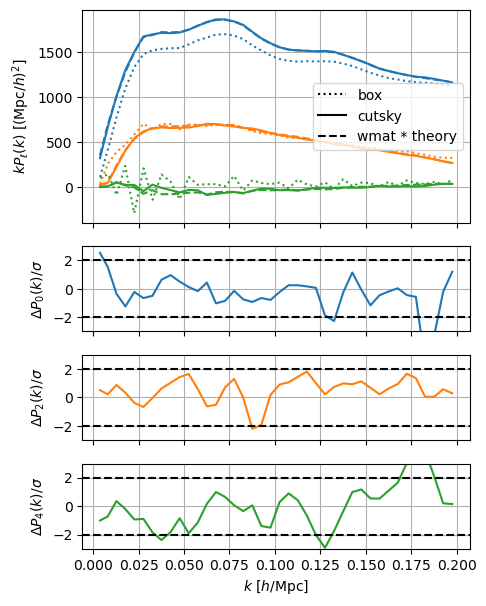

In [6]:
pks = [Spectrum2Poles.load(get_measurement_fn(imock=imock, **catalog_args, kind='mesh2spectrum_rotated')) for imock in range(nmocks)]
pk_cutsky = Spectrum2Poles.mean(pks)
cov_cutsky = Spectrum2Poles.cov(pks)
cov_cutsky = cov_cutsky_thetacut.clone(value=np.diag(np.diag(cov_cutsky_thetacut.view())))
wmat_cutsky = WindowMatrix.load(get_measurement_fn(imock=0, **catalog_args, kind='window_mesh2spectrum_rotated'))

plot_validation(pk_box, pk_cutsky, pk_theory_callable, wmat_cutsky, cov_cutsky,
                klim=(0., 0.2), marg_shotnoise=False)